<a href="https://colab.research.google.com/github/iProlly/Comchem/blob/main/Oil_ML_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from google.colab import drive
from random import randrange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import io

In [ ]:
raw = pd.read_csv('/content/IR_Phychem_Nic.csv')

testing_number = 400
testing_data = []
testing_labels = []

labels = raw.iloc[:, 0].values
data = raw.iloc[:, 1:].values

for j in range(testing_number):
  random_index = randrange(len(data))
  testing_labels.append(labels[random_index])
  testing_data.append(data[random_index])
  data = np.delete(data, random_index, 0)
  labels = np.delete(labels, random_index, 0)

testing_data = np.array(testing_data)
testing_labels = np.array(testing_labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_train = X_train[..., np.newaxis]  # Add channel dimension for CNN
X_test = X_test[..., np.newaxis]
testing_data = testing_data[..., np.newaxis]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(data.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.2898 - loss: 9271.0654 - val_accuracy: 0.2667 - val_loss: 363.1161
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.3493 - loss: 148.1891 - val_accuracy: 0.5417 - val_loss: 13.8394
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.5480 - loss: 12.1494 - val_accuracy: 0.4583 - val_loss: 18.9448
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.5484 - loss: 15.8568 - val_accuracy: 0.6896 - val_loss: 4.8082
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.6454 - loss: 5.8506 - val_accuracy: 0.6313 - val_loss: 4.7872
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.6261 - loss: 7.8140 - val_accuracy: 0.5271 - val_loss: 10.9178
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6684 - loss: 4.9714 - val_accuracy: 0.7104 - val_loss: 2.9119
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.7495 - loss: 2.0919 - val_

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6007 - loss: 4.4487
Test accuracy: 61.87%


In [ ]:
prediction = model.predict(testing_data)

# Get the index of the highest probability
predicted_class_index = np.argmax(prediction, axis=1)

# Decode the prediction to get the class label
predicted_class = label_encoder.inverse_transform(predicted_class_index)

point = 0
for i in range(len(predicted_class)):
  if predicted_class[i] == testing_labels[i]:
    point+=1
print("Percentage accuracy:", point/len(predicted_class)*100)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Percentage accuracy: 57.75


Confusion Matrix in Table Format:
       'O01'  'O02'  'O03'  'O04'
'O01'     38     19     38      0
'O02'      0     73     13      0
'O03'      0     49     56      1
'O04'      0      6     43     64


<Figure size 800x600 with 0 Axes>

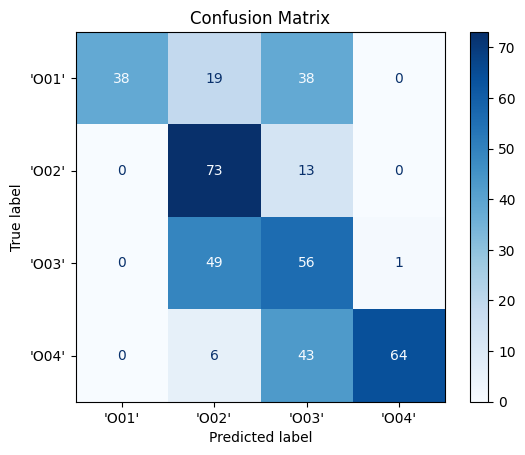

In [ ]:
conf_matrix = confusion_matrix(testing_labels, predicted_class)

# Optional: Display the confusion matrix as a formatted table
# Convert integer labels back to original string labels
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=label_encoder.classes_,  # Rows (True Labels)
    columns=label_encoder.classes_  # Columns (Predicted Labels)
)

# Display the confusion matrix
print("Confusion Matrix in Table Format:")
print(conf_matrix_df)

# Step 5: Visualize the Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()